<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/object_detection/pedestrian_detection_and_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we will train a model for pedestrian detection and segmentation using Penn-Fudan Database. It contains 170 images with 345 labeled pedestrians. Each image has at least one pedestrian in it.

The process will be broken into the following steps:

1.   Load and visualize the dataset
2.   Create a custom dataset
3.   Define a neural network
4.   Define an optimizer
5.   Train the model on the training dataset
6.   Evaluate the performance of the trained model on the test dataset

In [85]:
# import required libraries

import torch
import torchvision
from torchvision import models, transforms

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-r7dkvx6m
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-r7dkvx6m
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264335 sha256=fb2d28c5930c6bec249608d8d7e7cfde1820b4eb566dead608cc4cafdea157c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-2qoa970m/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [3]:
%%shell

# Download TorchVision repo to use some files from references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 139057, done.
remote: Counting objects: 100% (5274/5274), done.
remote: Compressing objects: 100% (559/559), done.
remote: Total 139057 (delta 4829), reused 5088 (delta 4693), pack-reused 133783
Receiving objects: 100% (139057/139057), 271.95 MiB | 26.69 MiB/s, done.
Resolving deltas: 100% (122328/122328), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [13]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.')
else:
  print('CUDA is avaiable!')

CUDA is avaiable!


In [14]:
device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

### Load and visualize dataset

In [5]:
%%shell
# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2022-05-17 09:39:00--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  27.1MB/s    in 1.9s    

2022-05-17 09:39:02 (27.1 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-05-17 09:39:02--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-05-17 09:39:02--
Total wall clock time: 2.2s
Downloaded: 1 files, 51M in 1.9s (27.1 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

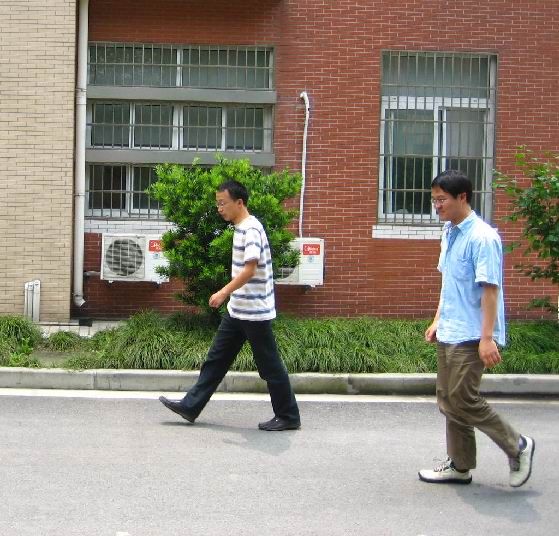

In [6]:
# visualize an image
img = Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
img

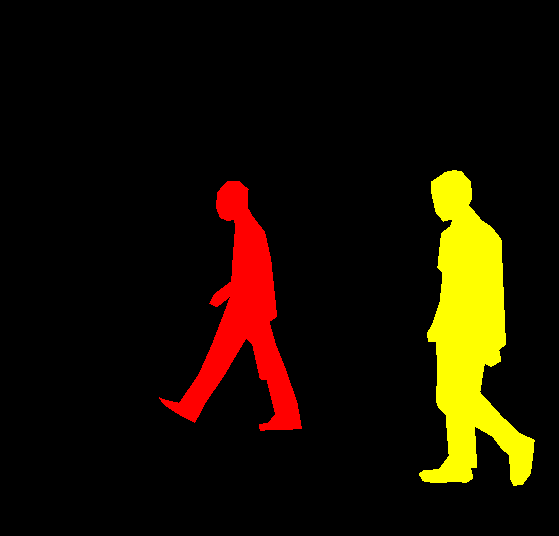

In [10]:
# visualize an image with labeled mask

mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')

# Each image has a corresponding segmentation mask, where each mask instance has 
# a different color and each color correspond to a different instance, 
# (from 0 to N, where 0 is the background and N is the number of instances). 
# In order to make visualization easier, let's add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

### Create a custom dataset

The only change that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size --> (h,w)
* target: a dictionary containing the following
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.

In [11]:
# create a custom dataset 

class PedestrianDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # sort all the images
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        # convert images to RGB
        img = Image.open(img_path).convert("RGB")
        # masks don't need to convert to RGB because each color corresponds to a 
        # different instance with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [15]:
import transforms as T

# helper function for data augmentation

def get_transform(train):
    transforms = []
    # converts the image into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [38]:
import utils

# we don't need to normalize/rescale images in the data transforms
# as they are handeled internally by the Mask R-CNN model

train_data = PedestrianDataset('PennFudanPed', get_transform(train=True))
test_data = PedestrianDataset('PennFudanPed', get_transform(train=False))

# split the dataset into train and test set
torch.manual_seed(1)
indices = torch.randperm(len(train_data)).tolist()
train_data = torch.utils.data.Subset(train_data, indices[:-50])
val_data = torch.utils.data.Subset(test_data, indices[-50:])

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

In [39]:
for imgs in train_loader:
  break
print(type(imgs))

<class 'tuple'>


In [43]:
imgs[0]

(tensor([[[0.1176, 0.1176, 0.1176,  ..., 0.4471, 0.4392, 0.4314],
          [0.1216, 0.1216, 0.1216,  ..., 0.4784, 0.4667, 0.4510],
          [0.1255, 0.1255, 0.1255,  ..., 0.5020, 0.4863, 0.4627],
          ...,
          [0.7765, 0.7765, 0.7765,  ..., 0.8706, 0.8627, 0.8588],
          [0.7843, 0.7765, 0.7765,  ..., 0.8667, 0.8588, 0.8549],
          [0.7843, 0.7765, 0.7765,  ..., 0.8667, 0.8588, 0.8549]],
 
         [[0.1216, 0.1216, 0.1216,  ..., 0.5176, 0.5020, 0.4941],
          [0.1255, 0.1255, 0.1255,  ..., 0.5490, 0.5294, 0.5137],
          [0.1294, 0.1294, 0.1294,  ..., 0.5725, 0.5490, 0.5255],
          ...,
          [0.7255, 0.7255, 0.7255,  ..., 0.8667, 0.8588, 0.8549],
          [0.7255, 0.7255, 0.7255,  ..., 0.8667, 0.8588, 0.8549],
          [0.7255, 0.7255, 0.7255,  ..., 0.8667, 0.8588, 0.8549]],
 
         [[0.0902, 0.0902, 0.0902,  ..., 0.4157, 0.3882, 0.3804],
          [0.0941, 0.0941, 0.0941,  ..., 0.4471, 0.4157, 0.4000],
          [0.0980, 0.0980, 0.0980,  ...,

In [42]:
imgs[1]

({'area': tensor([30250., 27542., 42744., 12496.]),
  'boxes': tensor([[451.,  88., 561., 363.],
          [321.,  55., 415., 348.],
          [ 36.,  36., 173., 348.],
          [149.,  46., 220., 222.]]),
  'image_id': tensor([141]),
  'iscrowd': tensor([0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
 

### Define a neural network

In [44]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def segmentation_model(num_classes):
    # load a pre-trained segmentation model pre-trained on COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [45]:
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = segmentation_model(num_classes)
# move model to the right device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

### Define an optimizer

In [86]:
from torch.optim.lr_scheduler import StepLR

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# construct a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### Train the model

In [52]:
from engine import train_one_epoch, evaluate

# let's train it for 30 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_loader, device=device)

Epoch: [0]  [ 0/60]  eta: 0:00:30  lr: 0.000090  loss: 0.3906 (0.3906)  loss_classifier: 0.0486 (0.0486)  loss_box_reg: 0.1475 (0.1475)  loss_mask: 0.1824 (0.1824)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 0.5069  data: 0.2078  max mem: 3714
Epoch: [0]  [10/60]  eta: 0:00:17  lr: 0.000936  loss: 0.3146 (0.3058)  loss_classifier: 0.0421 (0.0470)  loss_box_reg: 0.1025 (0.1057)  loss_mask: 0.1242 (0.1434)  loss_objectness: 0.0008 (0.0030)  loss_rpn_box_reg: 0.0065 (0.0066)  time: 0.3459  data: 0.0253  max mem: 3714
Epoch: [0]  [20/60]  eta: 0:00:13  lr: 0.001783  loss: 0.2646 (0.2953)  loss_classifier: 0.0417 (0.0463)  loss_box_reg: 0.0845 (0.0987)  loss_mask: 0.1242 (0.1413)  loss_objectness: 0.0013 (0.0029)  loss_rpn_box_reg: 0.0057 (0.0061)  time: 0.3261  data: 0.0067  max mem: 3714
Epoch: [0]  [30/60]  eta: 0:00:09  lr: 0.002629  loss: 0.2530 (0.2859)  loss_classifier: 0.0395 (0.0446)  loss_box_reg: 0.0828 (0.0945)  loss_mask: 0.1237 (0.1389)  loss_ob

### Evaluate the performance of the trained model on a test dataset

In [81]:
# pick an image from the validation dataset
img, _ = test_data[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [82]:
print(prediction)

[{'boxes': tensor([[200.2227, 104.9550, 352.8419, 388.2031],
        [  0.0000, 107.3172,  91.5882, 382.8957],
        [ 33.6890,  96.5000,  98.4766, 333.7844],
        [282.8002,  91.5431, 357.0226, 373.5208]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.9859, 0.8364, 0.0788], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0.

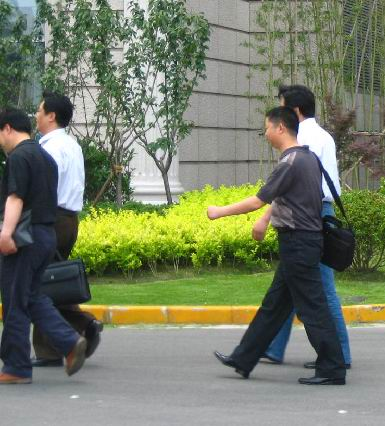

In [83]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

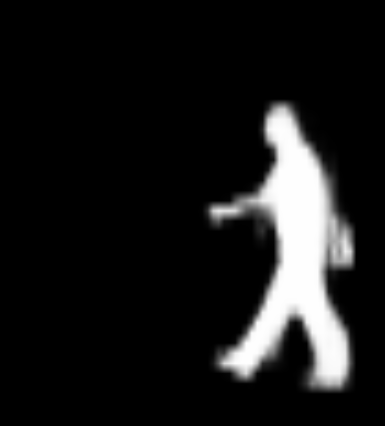

In [84]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())